# Install dependencies

In [2]:
!pip install --quiet fasttext

     |████████████████████████████████| 71kB 4.8MB/s 


In [ ]:
!wget https://raw.githubusercontent.com/sambit9238/Deep-Learning/master/sarcasm_classifier/Sarcasm_Headlines_Dataset_v2.json -O Sarcasm_Headlines_Dataset_v2.json

In [15]:
!ls -a
!head -n 20 Sarcasm_Headlines_Dataset_v2.json

 .
 ..
 .config
'data?select=Sarcasm_Headlines_Dataset_v2.json'
 fastText
 sample_data
 Sarcasm_Headlines_Dataset_v2.json
{"is_sarcastic": 1, "headline": "thirtysomething scientists unveil doomsday clock of hair loss", "article_link": "https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205"}
{"is_sarcastic": 0, "headline": "dem rep. totally nails why congress is falling short on gender, racial equality", "article_link": "https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207"}
{"is_sarcastic": 0, "headline": "eat your veggies: 9 deliciously different recipes", "article_link": "https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html"}
{"is_sarcastic": 1, "headline": "inclement weather prevents liar from getting to work", "article_link": "https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031"}
{"is_sarcastic": 1, "headline": "mother comes pretty close to usin

# Load data

In [16]:
#load data
import pandas as pd

df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = df.sample(frac=1).reset_index(drop=True)

# show first few rows
df.head()

,is_sarcastic,headline,article_link
0,0,4 business mistakes i'll never make again,https://www.huffingtonpost.com/entry/4-busines...
1,1,450-pound man didn't go to doctor for a lecture,https://local.theonion.com/450-pound-man-didnt...
2,0,"fox news host disavows internment camps, after...",https://www.huffingtonpost.com/entry/fox-news-...
3,0,pentagon planning,https://www.huffingtonpost.com/entry/pentagon-...
4,0,how nikki haley helped fuel the homebuilding i...,https://www.huffingtonpost.com/entry/nikki-hal...


# Data visualization

In [18]:
#utility for data inspection
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud(headlines, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
    wc = WordCloud(background_color ='white',
                   min_font_size = 12)
    wc = wc.generate(headlines)
    plt.axis('off')
    plt.imshow(wc)

 num  num  num pound man didnt go to doctor for a lecture obama trying out social policies in second life nasa launches first cordless satellite abc reannounces cancellation of mr sunshine just to destroy matthew perry a little more  num  num  num  num  num  sports fans doing whatever dancing fluorescent chicken tells them tenants feel guilty asking elderly maintenance man to fix anything limbaugh says drug addiction a remnant of clinton administration report more television viewers becoming desensitized to drama allstate charged with operating protection racket nancy grace reports own mind now missing for  num  num  days panic rapidly setting in as man realizes he has no plan for ripe avocado survey genital stimulation maintains popularity producer tells actress nondisclosure agreement pretty standard for getting away with abusing his power olympic torch used to ignite tibetan protesters fbi declassifies j edgar hoovers extensive file on the munster family family wealthy enough to hav

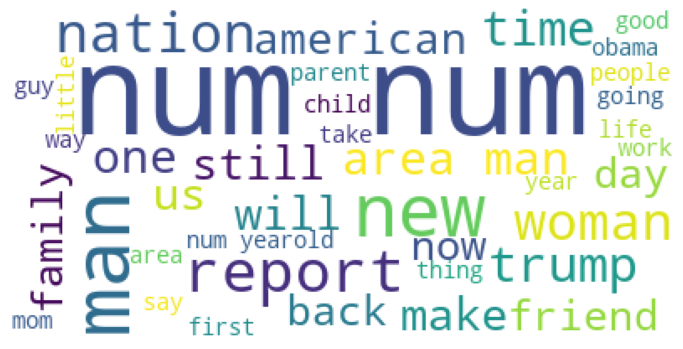

In [40]:
#word cloud on sarcastic headlines
sarcastic = ' '.join(df[df['is_sarcastic']==1]['headline'].to_list())
plot_wordcloud(sarcastic, 'Reds')

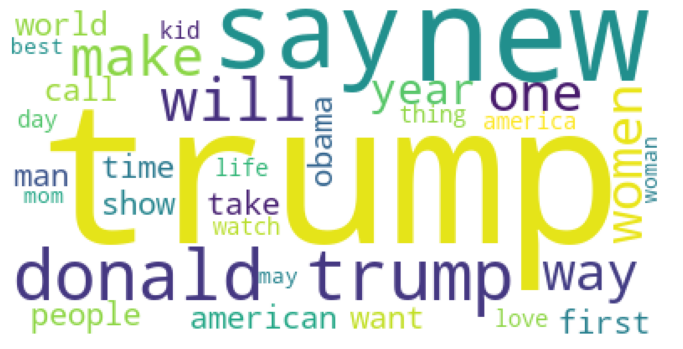

In [20]:
#word cloud on sarcastic headlines
sarcastic = ' '.join(df[df['is_sarcastic']==0]['headline'].to_list())
plot_wordcloud(sarcastic, 'Reds')

# Data cleaning

In [22]:
# removing non alphanumeric character
import re

def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

def replace_num(text):
    return re.sub(r'[0-9]', ' _NUM_ ', text)

df['headline'] = df['headline'].str.lower()
df['headline'] = df['headline'].apply(alpha_num)
df['headline'] = df['headline'].apply(replace_num)
df.head()

,is_sarcastic,headline,article_link
0,0,num business mistakes ill never make again,https://www.huffingtonpost.com/entry/4-busines...
1,1,num num num pound man didnt go to doctor fo...,https://local.theonion.com/450-pound-man-didnt...
2,0,fox news host disavows internment camps after ...,https://www.huffingtonpost.com/entry/fox-news-...
3,0,pentagon planning,https://www.huffingtonpost.com/entry/pentagon-...
4,0,how nikki haley helped fuel the homebuilding i...,https://www.huffingtonpost.com/entry/nikki-hal...


# Data preparation

In [23]:
#data preparation for fasttext
with open('fasttext_input_sarcastic_comments.txt', 'w') as f:
    for each_text, each_label in zip(df['headline'], df['is_sarcastic']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [24]:
!head -n 10 fasttext_input_sarcastic_comments.txt

__label__0  num  business mistakes ill never make again
__label__1  num  num  num pound man didnt go to doctor for a lecture
__label__0 fox news host disavows internment camps after panelists suggest rounding up muslims
__label__0 pentagon planning
__label__0 how nikki haley helped fuel the homebuilding industrys war on fire sprinklers
__label__0 supreme court makes slipup in death penalty case
__label__1 obama trying out social policies in second life
__label__1 nasa launches first cordless satellite
__label__1 abc reannounces cancellation of mr sunshine just to destroy matthew perry a little more
__label__0 content marketing guide from the best content director awardee nic mccarthy


In [28]:
!wc -l fasttext_input_sarcastic_comments.txt

28619 fasttext_input_sarcastic_comments.txt


In [25]:
!head -n 25757 fasttext_input_sarcastic_comments.txt > sarcasm_train.bin

In [26]:
!tail -n 2862 fasttext_input_sarcastic_comments.txt > sarcasm_test.bin

# Training

In [30]:
import fasttext

'''
For classification train_supervised call will be used:

The default parameters to it:
    input             # training file path (required)
    lr                # learning rate [0.1]
    dim               # size of word vectors [100]
    ws                # size of the context window [5]
    epoch             # number of epochs [5]
    minCount          # minimal number of word occurences [1]
    minCountLabel     # minimal number of label occurences [1]
    minn              # min length of char ngram [0]
    maxn              # max length of char ngram [0]
    neg               # number of negatives sampled [5]
    wordNgrams        # max length of word ngram [1]
    loss              # loss function {ns, hs, softmax, ova} [softmax]
    bucket            # number of buckets [2000000]
    thread            # number of threads [number of cpus]
    lrUpdateRate      # change the rate of updates for the learning rate [100]
    t                 # sampling threshold [0.0001]
    label             # label prefix ['__label__']
    verbose           # verbose [2]
    pretrainedVectors # pretrained word vectors (.vec file) for supervised learning []
'''
model = fasttext.train_supervised('sarcasm_train.bin', wordNgrams=2)

In [33]:
#measuring performance on test data
def print_results(sample_size, precision, recall):
    precision   = round(precision, 2)
    recall      = round(recall, 2)
    print(f'sample_size: {sample_size}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')

print_results(*model.test('sarcasm_test.bin'))

sample_size: 2862
precision: 0.86
recall: 0.86


In [34]:
#save the model
model.save_model('fasttext_sarcasm.model')

In [36]:
!ls -alh

total 784M
drwxr-xr-x  1 root root 4.0K Jul  6 14:41  .
drwxr-xr-x  1 root root 4.0K Jul  6 14:16  ..
drwxr-xr-x  4 root root 4.0K Jun 15 13:37  .config
-rw-r--r--  1 root root  63K Jul  6 14:23 'data?select=Sarcasm_Headlines_Dataset_v2.json'
drwxr-xr-x 13 root root 4.0K Jul  6 14:21  fastText
-rw-r--r--  1 root root 2.1M Jul  6 14:36  fasttext_input_sarcastic_comments.txt
-rw-r--r--  1 root root 774M Jul  6 14:42  fasttext_sarcasm.model
drwxr-xr-x  1 root root 4.0K Jun 15 13:37  sample_data
-rw-r--r--  1 root root 5.8M Jul  6 14:28  Sarcasm_Headlines_Dataset_v2.json
-rw-r--r--  1 root root 208K Jul  6 14:37  sarcasm_test.bin
-rw-r--r--  1 root root 1.9M Jul  6 14:37  sarcasm_train.bin


In [ ]:
# Load model and predict

In [37]:
model = fasttext.load_model("fasttext_sarcasm.model")

In [39]:
print(model.labels)

['__label__0', '__label__1']


In [38]:
model.predict("Make American manufacturing competitive to curb Chinese imports?")

(('__label__0',), array([0.60957968]))